Javier García Serrano, Ana Gil Molina

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 1:  (2 puntos)</strong></div>

**Explica en detalle cómo funciona el modelo de Bahdanau, sobre la implementación que se ha usado en esta práctica y usando como apoyo el paper que se ha referenciado. Si se considera conveniente, usa el propio ejecuciones parciales (i.e. fragmentos) del propio código para proporcionar dichas explicaciones. Referencia también el mecanismo de visualización que se ha usado para los cuatro ejemplos que acabas de ver basados en las matrices de atención.**

### **Introducción**

El modelo de atención de Bahdanau, introducido en el paper "*Neural Machine Translation by Jointly Learning to Align and Translate*" de Dzmitry Bahdanau, KyungHyun Cho y Yoshua Bengio, es un mecanismo introducido en el campo de la traducción automática con redes neuronales, mediante el cual se consigue que el modelo "preste atención" a diferentes partes de la entrada mientras se está generando la salida, en lugar de usar la representación fija producida por un encoder, como era habitual en los modelos de secuencia a secuencia tradicionales.

Antes de la introducción de la atención, las redes secuencia a secuencia, también llamadas arquitecturas encoder-decoder, usaban un encoder encargado de procesar la frase de entrada, transformándola en un vector de longitud fija a partir del cual el decoder generaba la traducción. El problema de este enfoque era que la red neuronal debía ser capaz de comprimir toda la información necesaria de la entrada en un vector de longitud fija, lo cual podía dificultarse en el caso de trabajar con frases largas, resultando en pérdidas de información.

Bahdanau propuso un enfoque innovador en el que, en lugar de utilizar un único vector de contexto, el modelo aprende a seleccionar las partes de la secuencia de entrada más relevantes a la hora de predecir cada palabra de salida. El encoder convierte cada palabra de entrada en un vector de estado oculto, produciendo una secuencia de vectores en lugar de un solo vector. Luego, el mecanismo de atención calcula un peso para cada uno de estos vectores en función de su relevancia para la palabra de salida que se está generando. Estos pesos de atención, normalizados mediante softmax, se utilizan para producir un vector de contexto adaptativo, específico para cada paso de salida.

Este enfoque permite al modelo prestar atención a diferentes palabras de la entrada de forma dinámica, lo cual es particularmente útil en frases largas o complejas, ya que mejora la precisión y coherencia en la generación de la traducción, adaptándose a la estructura de cada oración en función del contexto.

Desde un punto de vista probabilístico, traducir es equivalente a encontrar una frase de salida $y$ que maximice la probabilidad condicional de $y$ dado una frase de entrada $x$, es decir, encontrar $\arg\max_y p(y|x)$. En el método clásico de traducción mediante modelos encoder-decoder con redes recurrentes (RRN), el encoder lee la frase de entrada, una secuencia de vectores $x = (x_1,\dots, x_{T_x})$, y la convierte en un vector de contexto $c$. Se usa una RNN de forma que:

$$h_t = f(x_t,h_{t-1})$$

$$c = q(\{h_1, \dots, h_{T_x}\})$$

donde $h_t \in \mathbb{R}^n$ es un estado oculto en $t$, $c$ es un vector generado de la secuencia de estados ocultos, y $f$ y $q$ son funciones no lineales.

El decoder se entrena para predecir la siguiente palabra $y_{t'}$ dado el vector de contexto $c$ y las palabras predichas anteriormente $\{y_1,\dots, y_{t'-1}\}$. Esto es, se define una probabilidad para la traducción $y = (y_1,\dots,y_{T_y})$ como:

$$p(y) = \prod_{t=1}^{T} p(y_t \mid \{y_1, \dots, y_{t-1}\}, c)$$

Donde cada probabilidad condicional se modela con un RNN como:

$$p(y_t \mid \{y_1, \dots, y_{t-1}\}, c) = g(y_{t-1}, s_t, c)$$

donde $g$ es una función no lineal multicapa, y $s_t$ es el estado oculto de la RNN.

### **Modelo de Bahdanau**

Si bien el modelo clásico de encoder-decoder con redes recurrentes permite generar traducciones mediante un vector fijo de contexto $c$, este enfoque presenta limitaciones, pues esta representación fija no puede capturar toda la información relevante de la frase de entrada, llevando a traducciones menos precisas. Para superar esta limitación, Bahdanau propuso un mecanismo de atención consistente en una RNN bidireccional como encoder, y un decoder que busca a lo largo de la frase de entrada durante la traducción.

#### **Encoder**

En el paper de Bahdanau se presenta un encoder bidireccional (BiRNN), el cual consiste en una RNN que procesa la secuencia en el orden original (de $x_1$ a $x_{T_x}$), y calcula una secuencia de estados ocultos hacia adelante $(\overrightarrow{h}_1,\dots, \overrightarrow{h}_{T_x})$ y otra RNN que la procesa en orden inverso (de $x_{T_x}$ a $x_1$), calculando una secuencia de estados ocultos hacia atrás $(\overleftarrow{h}_1,\dots, \overleftarrow{h}_{T_x})$. Por ejemplo, los estados ocultos hacia adelante se calculan como:

$$
\overrightarrow{h}_i =
\begin{cases}
(1 - \overrightarrow{z}_i) \cdot \overrightarrow{h}_{i-1} + \overrightarrow{z}_i \cdot \overrightarrow{\underline{h}}_i, & \text{si } i > 0 \\
0, & \text{si } i = 0
\end{cases}
$$

donde:

$$\overrightarrow{\underline{h}}_i = \tanh \left( \overrightarrow{W} \overline{E} x_i + \overrightarrow{U}  \left[\overrightarrow{r}_i \circ \overrightarrow{h}_{i-1} \right] \right)$$

$$\overrightarrow{z}_i = \sigma \left( \overrightarrow{W}_z \overline{E} x_i + \overrightarrow{U}_z \overrightarrow{h}_{i-1} \right)$$

$$\overrightarrow{r}_i = \sigma \left( \overrightarrow{W}_r \overline{E} x_i + \overrightarrow{U}_r \overrightarrow{h}_{i-1} \right)$$

con $\overline{E}$ la matriz de embedding de palabras. De forma equivalente se obtienen los estados ocultos hacia atrás.

Así, para cada palabra $x_j$ se obtiene la anotación $h_j = [\overrightarrow{h_j^T};\overleftarrow{h_j^T}]^T$.

Usar un encoder bidireccional ayuda a que el modelo capture mejor el contexto, ya que cada palabra tiene un vector de anotación que incorpora tanto información pasada como futura. Sin embargo, dado que las arquitecturas bidireccionales requieren más memoria y procesamiento, en nuestra práctica hemos usado arquitectura más simple formada por una red GRU (Gated Recurrent Unit) unidireccional. Veamos en detalle el código del encoder:

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Observamos que se usa un embedding para los tokens, encargado de representar cada palabra de la secuencia de entrada como un vector, facilitando el aprendizaje. Este vector pasa por una capa de dropout, lo que ayuda a reducir el sobreajuste.

Luego, estos embeddings se procesan en la capa GRU unidireccional. La GRU, similar a una LSTM pero más simple, es una red recurrente que para cada secuencia de entrada genera una salida (`output`) y un estado oculto (`hidden`). La salida es una secuencia de estados ocultos que contiene un vector por cada palabra en la frase, los cuales son usados más adelante en el mecanismo de atención del decoder. El estado oculto final `hidden` contiene la información de toda la secuencia y se pasa al decoder como el estado inicial para iniciar la generación de la traducción.

#### **Decoder**

En el paper de Bahdanau, el decoder incorpora un mecanismo de atención, el cual permite que cada palabra generada en la secuencia de salida tenga su propio contexto adaptado. A diferencia de los enfoques tradicionales, donde la probabilidad de cada palabra de salida $y_i$ dependía de un único vector de contexto global, aquí se calcula un vector de contexto específico $c_i$ para cada palabra de salida. Este vector de contexto depende tanto del estado oculto anterior del decoder como de una ponderación de los estados del encoder. Así, la probabilidad condicional de $y_i$ se obtiene como:

$$p(y_i \mid y_1, \dots, y_{i-1}, x) = g(y_{i-1}, s_i, c_i)$$

donde $s_i = (1-z_i) \circ s_{i-1} + z_i \circ \tilde{s}_i$ es el estado oculto del decoder en el paso $i$ (el estado inicial es $s_0 = \tanh(W_s \overrightarrow{h}_1)$), con:

$$\tilde{s}_i = \tanh (W E  y_{i-1} + U [r_i \circ s_{i-1}] + C c_i)$$

$$z_i = \sigma (W_z E y_{i-1} + U_z s_{i-1} + C_z c_i)$$

$$r_i = \sigma (W_r E y_{i-1} + U_r s_{i-1} + C_r c_i)$$

El vector de contexto $c_i$ se obtiene como una suma ponderada de las anotaciones $h_j$ (estados ocultos del encoder que contienen información de cada palabra de la secuencia de entrada):

$$c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j$$

donde $T_x$ es la longitud de la secuencia de entrada, y los pesos de atención:

$$\alpha_{ij} = softmax(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k=1}^{T_x} \exp(e_{ik})}$$

con $e_{ij} = v_a^T \tanh(W_a s_{i-1} + U_a h_j)$, determinan la relevancia del estado $j$ del encoder en el estado $i$ del decoder para generar la salida $y_i$.

En nuestra práctica se presentan dos decoders. El primero, `DecoderRNN`, no utiliza atención, lo que significa que usa un único vector de contexto fijo proveniente del encoder:

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

 Este decoder es también una red recurrente de tipo GRU, que al inicio toma como entrada el estado oculto del encoder y el token especial `<SOS>` (start of string), que indica el comienzo de la secuencia.

 En las siguientes iteraciones, el decoder recibe como entrada el token generado en el paso anterior, o el token correcto si se usa *teacher forcing*. Este token se pasa primero a través de una capa de embedding para convertirlo en un vector de características. Luego, tanto el vector de entrada como el estado oculto del paso anterior se pasan a la GRU para generar el nuevo estado oculto y la salida correspondiente. La salida generada (`output`) se pasa por una capa softmax para obtener las probabilidades de cada palabra posible en la secuencia de salida.

 Por otro lado, se presenta un segundo decoder, `AttnDecoderRNN`, que sí utiliza un mecanismo de atención, concretamente, el modelo de atención de Bahdanau. Este decoder con atención tiene la capacidad de enfocarse selectivamente en diferentes partes de la secuencia de entrada a medida que genera cada palabra de la secuencia de salida. A continuación, pasamos a explicar cómo se implementa el modelo de Bahdanau en el código:

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

En primer lugar, se definen tres capas lineales que se emplean para calcular los pesos de atención (`Wa`, `Ua`, `Va`). A continuación, en el método `forward` se calculan los scores utilizando la fórmula $e_{ij} = v_a^T \tanh(W_a s_{i-1} + U_a h_j)$ vista en el paper. Estos scores se convierten en pesos mediante una capa softmax, transformándolos en probabilidades que suman $1$. Por último, se calcula el vector de contexto correspondiente utilizando los pesos de atención.

El mecanismo de atención de Bahdanau se integra entonces en el decoder, cuyo código se presenta a continuación:

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

Este decoder tiene varios componentes que se inicializan al comienzo:

- `self.embedding`: es una capa de embedding que convierte cada token en un vector.
- `self.attention`: es una instancia de `BahdanauAttention`, esto es, el mecanismo de atención de Bahdanau, que calcula el vector de contexto y los pesos de atención en cada paso.
- `self.gru`: es una capa GRU.
- `self.out`: es una capa lineal.
- `self.dropout`: es una capa que ayuda a prevenir el sobreajuste.

A continuación, en el método `forward` se recorre la secuencia, tomando como entrada inicial el token de inicio `<SOS>`. En cada paso se llama al método `forward_step` para calcular la salida, el nuevo estado oculto y los pesos de atención. Además, el `decoder_input` se puede obtener de dos maneras:

- Con *teacher forcing*: se usa el token correcto como entrada.
- Sin *teacher forcing*: se usa el token que el modelo predijo en el paso anterior.

Finalmente, se aplica un softmax logarítmico sobre las salidas para obtener la probabilidad de cada palabra.

### **Matrices de atención**

Para comprender mejor cómo traduce el modelo, se usa un mecanismo para visualizar cómo funciona la atención por medio de matrices de atención. Esto permite interpretar en qué tokens de la entrada se basa el modelo para generar cada palabra en la secuencia de salida.

En el código de la práctica, se usa la función `showAttention`, que emplea `plt.matshow(attentions)`, lo cual permite graficar la matriz de atención. En esta matriz, los valores más altos están representados por colores más claros, e indican un mayor peso de atención en una palabra de la secuencia de entrada para la palabra generada en la salida correspondiente. Los ejes se etiquetan con las palabras de la secuencia de entrada en el eje X, y las palabras de salida generadas en el eje Y.

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

Además de la función `showAttention`, también se emplea otra función `evaluateAndShowAttention`, que aplica todo el proceso de evaluación y visualización en una frase de entrada específica. Primero, llama a `evaluate` para obtener la traducción de la frase y la matriz de atención generada. Luego, llama a `showAttention`, que grafica la matriz de atención entre las palabras de entrada y las de salida, permitiéndonos ver en qué partes de la frase de entrada se enfoca el modelo para traducir cada palabra.

In [ ]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

Según el paper de Bahdanau, esta matriz de atención representa los pesos $\alpha_{ij}$, los cuales determinan la relevancia del estado $j$ del encoder en el estado $i$ del decoder para generar la salida $y_i$. Esto es, indican cuánta atención le da el decoder a una palabra de la entrada para generar una palabra de salida. En los ejemplos presentados en el paper (traducciones de inglés a francés), se observa que los pesos situados en la diagonal de las matrices suelen ser elevados, indicando que las palabras de la entrada y las de la salida están mayormente alineadas:

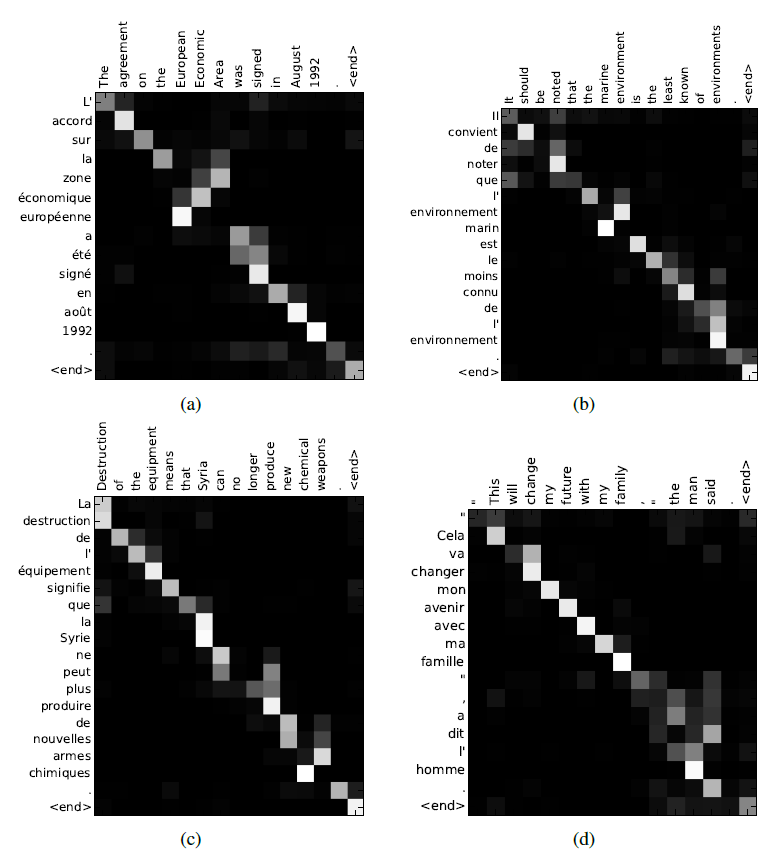

Sin embargo, también se encuentran pesos elevados fuera de la diagonal en ciertos casos. Por ejemplo, en el ejemplo (a), los pesos de los elementos $5$ y $7$ de la diagonal son bastante bajos, mientras que los de los elementos $(5,7)$ y $(7,5)$ son elevados. Esto es debido a que los sustantivos y los adjetivos se ordenan de forma diferente en inglés y en francés. Por otro lado, el peso elevado en la posición $(4,7)$, además de en el elemento $4$ de la diagonal, muestra que el modelo no solo se fija en el artículo "the" para traducirlo como "la" en francés, sino que también observa la palabra "Area" para determinar el género del artículo en la traducción.

En los ejemplos presentados en la práctica (traducciones de francés a inglés), al haber simplificado el entrenamiento del modelo y los datos utilizados, los resultados obtenidos no son tan buenos, lo cual se aprecia en las matrices de atención, que no muestran la relación entre las palabras de entrada y las de salida de una forma clara e interpretable. En este caso, las matrices de atención no presentan valores elevados en la diagonal. En cambio, muestran una distribución borrosa de los valores de atención.

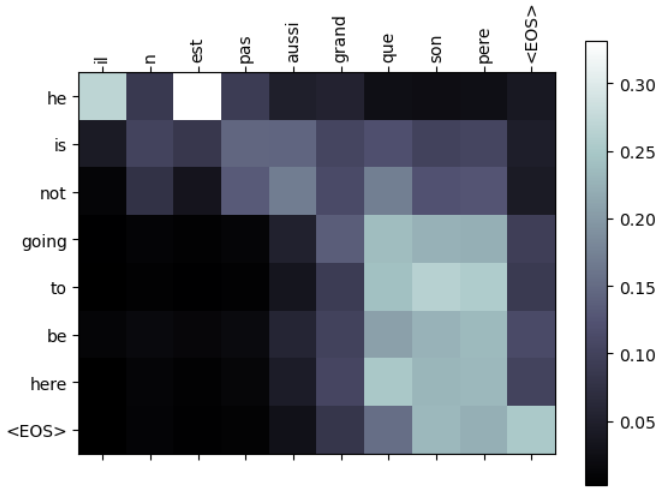

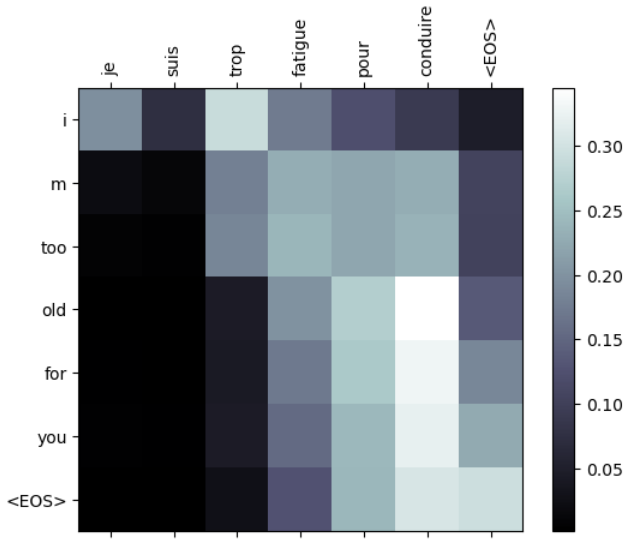

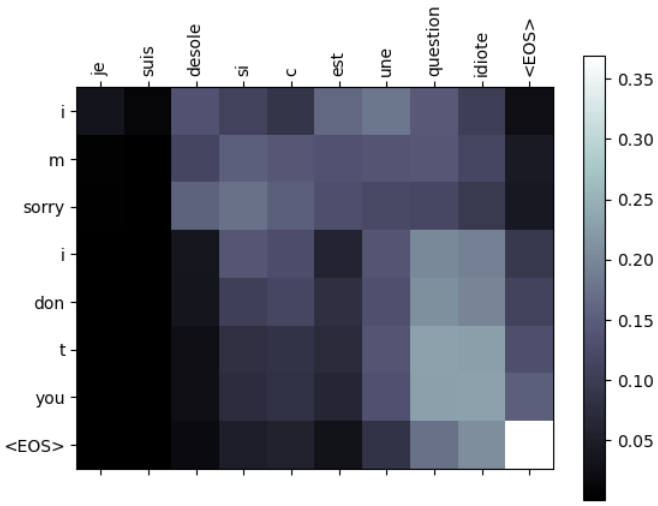

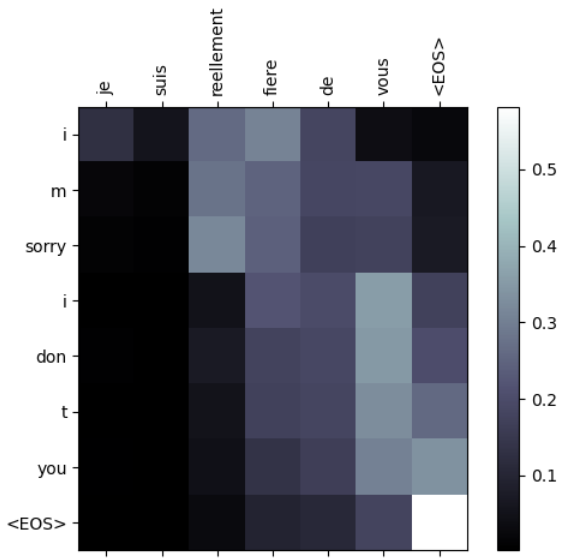